# Comparing embeddings

In the following I will compare the latent spaces obtained when using either scRNA-seq, scATAC-seq or both modalities to create the embeddings. For each modality I tried 3 different  of latent space dimensions, namely, 10, 15, 20.

In [17]:
import scanpy as sc
import scvi
import numpy as np
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_mutual_info_score
import pandas as pd

In [18]:
# create a dictionary to save ARI scores for different embeddings
metrics = {}

In [19]:
colPalette_celltypes = ['#532C8A',
 '#c19f70',
 '#f9decf',
 '#c9a997',
 '#B51D8D',
 '#3F84AA',
 '#9e6762',
 '#354E23',
 '#F397C0',
 '#ff891c',
 '#635547',
 '#C72228',
 '#f79083',
 '#EF4E22',
 '#989898',
 '#7F6874',
 '#8870ad',
 '#647a4f',
 '#EF5A9D',
 '#FBBE92',
 '#139992',
 '#cc7818',
 '#DFCDE4',
 '#8EC792',
 '#C594BF',
 '#C3C388',
 '#0F4A9C',
 '#FACB12',
 '#8DB5CE',
 '#1A1A1A',
 '#C9EBFB',
 '#DABE99',
 '#65A83E',
 '#005579',
 '#CDE088',
 '#f7f79e',
 '#F6BFCB']

# scRNA-seq

## PCA

In [20]:
adata = scvi.data.read_h5ad("gpu_trained_20_dim/anndata_object")


In [21]:
# compute pca
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=20)
sc.tl.umap(adata, min_dist=0.1)

In [22]:
# leiden clustering
sc.tl.leiden(adata, key_added="leiden_clusters", resolution=1.2)
print(f"Using Leiden clustering we obtain: {len(adata.obs.leiden_clusters.unique())} clusters")

Using Leiden clustering we obtain: 33 clusters


In [23]:
# kmeans clustering
emb = adata.obsm["X_pca"]
kmeans = KMeans(n_clusters=37,
                init="random",
                n_init=200,
                random_state=0).fit(emb)
adata.obs["kmeans"] = kmeans.labels_.astype(str)

... storing 'kmeans' as categorical


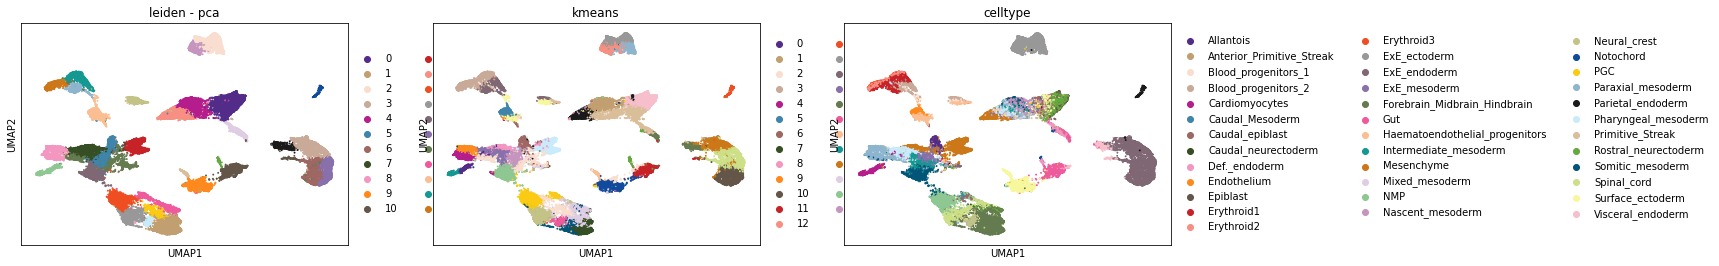

In [24]:
sc.pl.umap(adata, color=["leiden_clusters", "kmeans", "celltype"], title=["leiden - pca", "kmeans", "celltype"],palette = colPalette_celltypes, size = 15)

In [25]:
metrics["pca"] =  (adjusted_rand_score(adata.obs.celltype, adata.obs.leiden_clusters),adjusted_rand_score(adata.obs.celltype, adata.obs.kmeans),
               adjusted_mutual_info_score(adata.obs.celltype, adata.obs.leiden_clusters), 
               adjusted_mutual_info_score(adata.obs.celltype, adata.obs.kmeans))

## scVI

In [26]:
paths = ["gpu_trained_10_dim/", "gpu_trained_15_dim/", "gpu_trained_20_dim/"]

/omics/groups/OE0533/internal/katharina/scvi2/lib/python3.7/site-packages/scvi/data/_utils.py:102: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  "Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization."


Using Leiden clustering we obtain: 33 clusters
The adjusted Rand index when using Leiden clustering is: 0.5271701664976636


... storing 'kmeans' as categorical


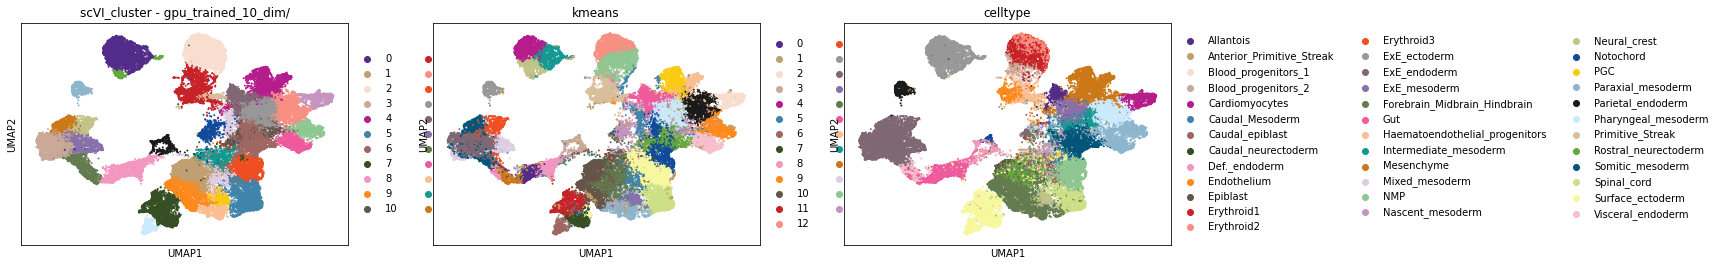

/omics/groups/OE0533/internal/katharina/scvi2/lib/python3.7/site-packages/scvi/data/_utils.py:102: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  "Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization."


Using Leiden clustering we obtain: 32 clusters
The adjusted Rand index when using Leiden clustering is: 0.5219546301005924


... storing 'kmeans' as categorical


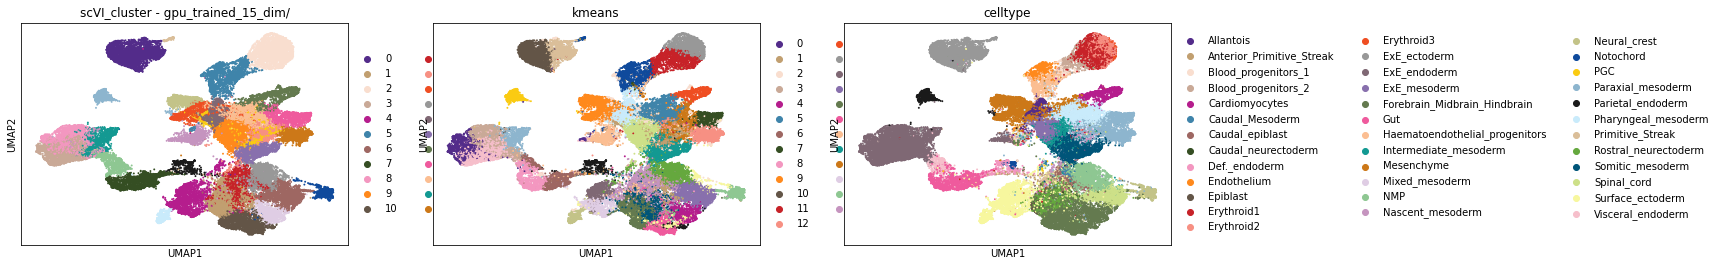

/omics/groups/OE0533/internal/katharina/scvi2/lib/python3.7/site-packages/scvi/data/_utils.py:102: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  "Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization."


Using Leiden clustering we obtain: 38 clusters
The adjusted Rand index when using Leiden clustering is: 0.49368517764805697


... storing 'kmeans' as categorical


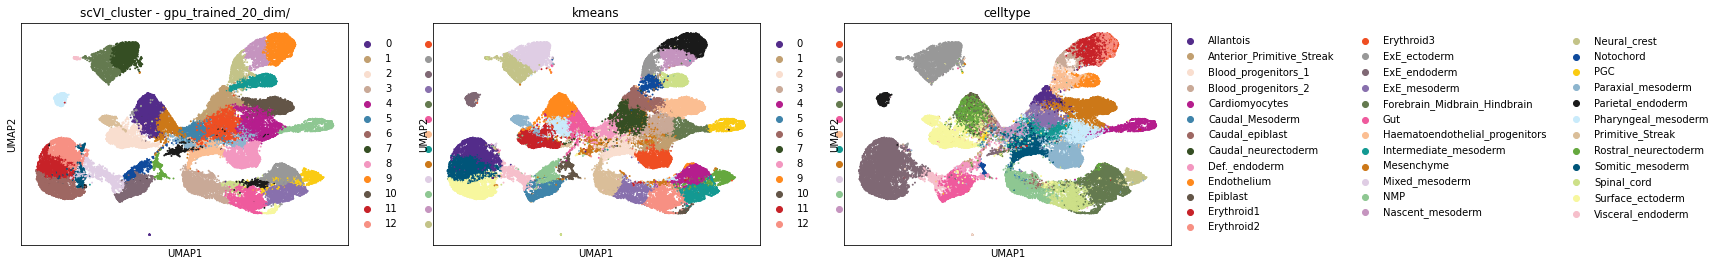

In [27]:
for p in paths:
    adata = scvi.data.read_h5ad(p + "anndata_object")
    model = scvi.model.SCVI.load(p, adata=adata, use_gpu=False)
    # use scVI latent space for UMAP generation
    sc.pp.neighbors(adata, use_rep="X_scVI")
    sc.tl.umap(adata, min_dist=0.3)
    
    # leiden clustering
    sc.tl.leiden(adata, key_added="scVI_clusters", resolution=1.2)
    print(f"Using Leiden clustering we obtain: {len(adata.obs.scVI_clusters.unique())} clusters")
    print(f"The adjusted Rand index when using Leiden clustering is: {adjusted_rand_score(adata.obs.celltype, adata.obs.scVI_clusters)}")
    
    # kmeans clustering
    emb = adata.obsm["X_scVI"]
    kmeans = KMeans(n_clusters=37,
                    init="random",
                    n_init=200,
                    random_state=0).fit(emb)
    adata.obs["kmeans"] = kmeans.labels_.astype(str)
    
    sc.pl.umap(adata, color=["scVI_clusters", "kmeans", "celltype"], title = [f"scVI_cluster - {p}", "kmeans", "celltype"], palette = colPalette_celltypes, size = 15)

    metrics[p] =  (adjusted_rand_score(adata.obs.celltype, adata.obs.scVI_clusters),adjusted_rand_score(adata.obs.celltype, adata.obs.kmeans),
                   adjusted_mutual_info_score(adata.obs.celltype, adata.obs.scVI_clusters), 
                   adjusted_mutual_info_score(adata.obs.celltype, adata.obs.kmeans))


# scATAC-seq

In [28]:
paths = ["atac_gpu_trained_10_dim/", "atac_gpu_trained_15_dim/", "atac_gpu_trained_20_dim/"]

Using Leiden clustering we obtain: 27 clusters


... storing 'kmeans' as categorical


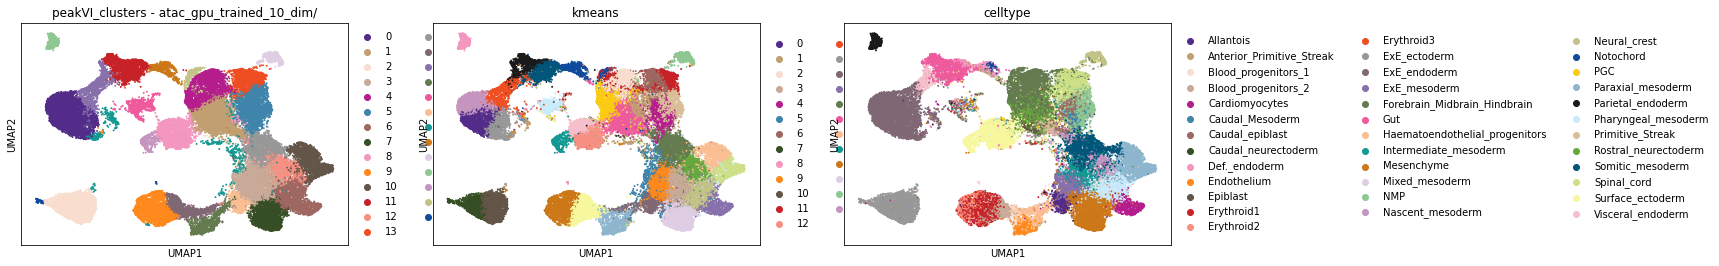

Using Leiden clustering we obtain: 29 clusters


... storing 'kmeans' as categorical


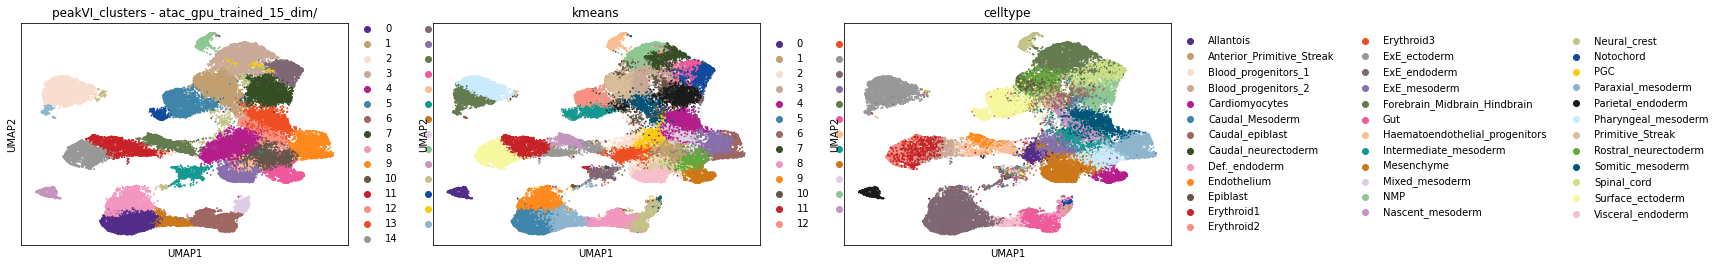

Using Leiden clustering we obtain: 27 clusters


... storing 'kmeans' as categorical


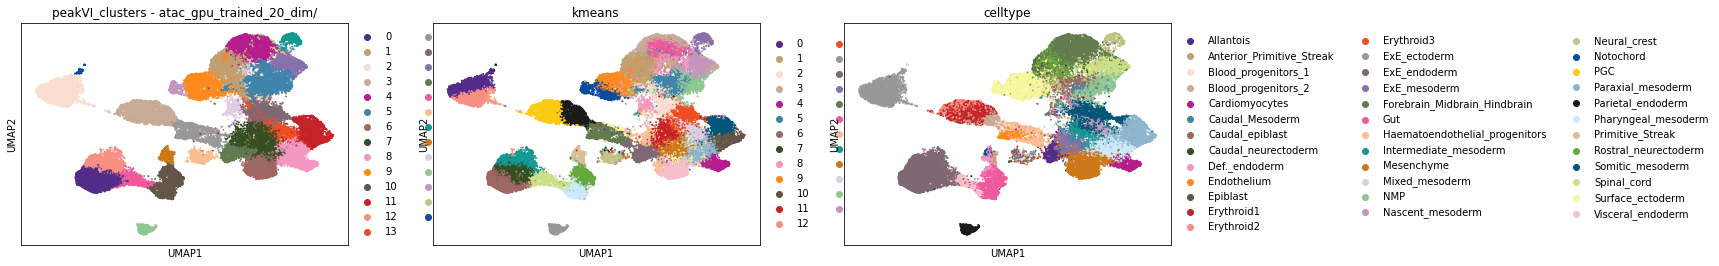

In [29]:
for p in paths:
    adata = scvi.data.read_h5ad(p + "anndata_object_peakvi")
    model = scvi.model.PEAKVI.load(p, adata=adata, use_gpu=False)
    # use scVI latent space for UMAP generation
    sc.pp.neighbors(adata, use_rep="X_PeakVI")
    sc.tl.umap(adata, min_dist=0.3)
    
    # leiden clustering
    sc.tl.leiden(adata, key_added="peakVI_clusters", resolution=1.2)
    print(f"Using Leiden clustering we obtain: {len(adata.obs.peakVI_clusters.unique())} clusters")
    
    # kmeans clustering
    emb = adata.obsm["X_PeakVI"]
    kmeans = KMeans(n_clusters=37,
                    init="random",
                    n_init=200,
                    random_state=0).fit(emb)
    adata.obs["kmeans"] = kmeans.labels_.astype(str)
    
    # plot umaps
    sc.pl.umap(adata, color=["peakVI_clusters", "kmeans", "celltype.mapped_mnn"], title = [f"peakVI_clusters - {p}", "kmeans", "celltype"], palette = colPalette_celltypes, size = 15)

    #print(f"The adjusted Rand index when using kmeans clustering is: {adjusted_rand_score(adata.obs["celltype.mapped_mnn"], adata.obs.peakVI_clusters)}")
    metrics[p] =  (adjusted_rand_score(adata.obs["celltype.mapped_mnn"], adata.obs.peakVI_clusters),adjusted_rand_score(adata.obs["celltype.mapped_mnn"], adata.obs.kmeans),
                   adjusted_mutual_info_score(adata.obs["celltype.mapped_mnn"], adata.obs.peakVI_clusters), 
                   adjusted_mutual_info_score(adata.obs["celltype.mapped_mnn"], adata.obs.kmeans))


# multiVI

In [30]:
paths = ["mvi_default/", "mvi_20_dim/"]#, "mvi_10_dim/"]

/omics/groups/OE0533/internal/katharina/scvi2/lib/python3.7/site-packages/scvi/data/_utils.py:102: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  "Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization."


Using Leiden clustering we obtain: 46 clusters


... storing 'kmeans' as categorical


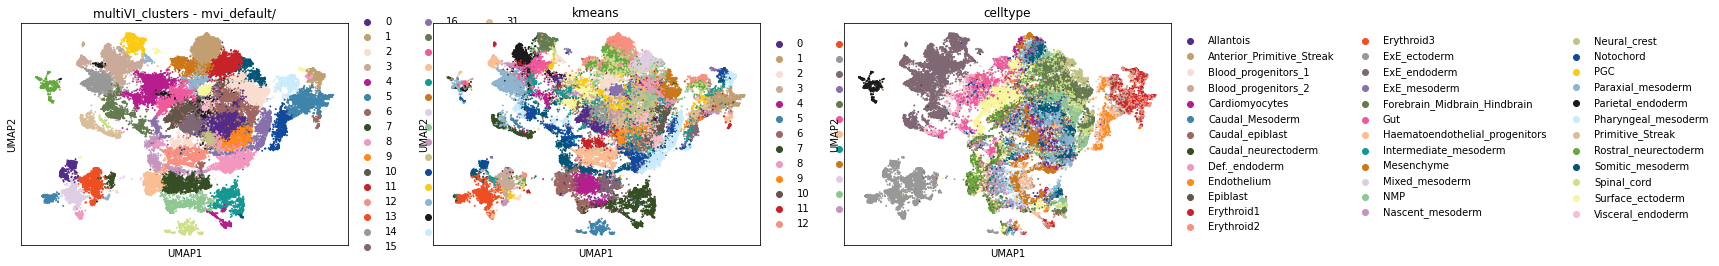

/omics/groups/OE0533/internal/katharina/scvi2/lib/python3.7/site-packages/scvi/data/_utils.py:102: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  "Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization."


Using Leiden clustering we obtain: 39 clusters


... storing 'kmeans' as categorical


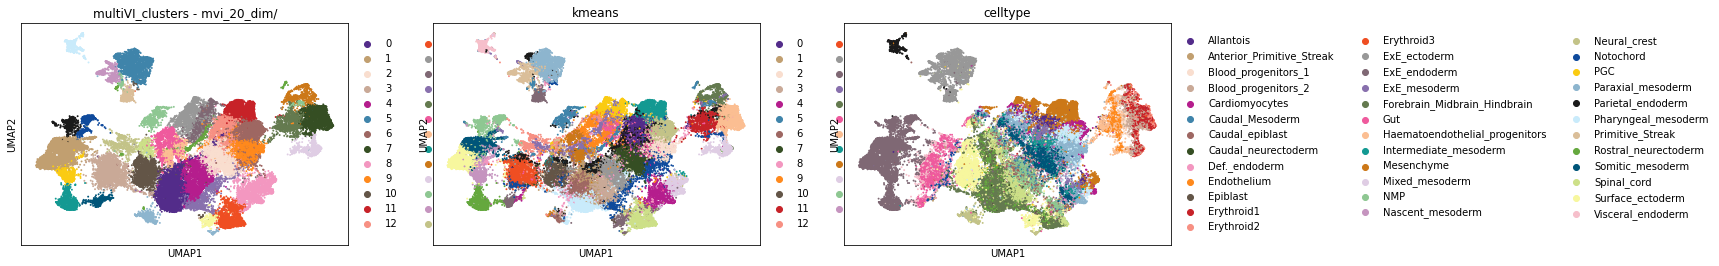

In [31]:
for p in paths:
    adata = scvi.data.read_h5ad(p + "anndata_object")
    model =  scvi.model.MULTIVI.load(p, adata=adata)
    # use scVI latent space for UMAP generation
    sc.pp.neighbors(adata, use_rep="X_multivi")
    sc.tl.umap(adata, min_dist=0.3)
    
    # leiden clustering
    sc.tl.leiden(adata, key_added="multiVI_clusters", resolution=1.2)
    print(f"Using Leiden clustering we obtain: {len(adata.obs.multiVI_clusters.unique())} clusters")
    
    # kmeans clustering
    emb = adata.obsm["X_multivi"]
    kmeans = KMeans(n_clusters=37,
                    init="random",
                    n_init=200,
                    random_state=0).fit(emb)
    adata.obs["kmeans"] = kmeans.labels_.astype(str)
    
    # plot umaps
    sc.pl.umap(adata, color=["multiVI_clusters", "kmeans", "celltype.mapped_mnn"], title = [f"multiVI_clusters - {p}", "kmeans", "celltype"], palette = colPalette_celltypes, size = 15)

    #print(f"The adjusted Rand index when using kmeans clustering is: {adjusted_rand_score(adata.obs["celltype.mapped_mnn"], adata.obs.peakVI_clusters)}")
    metrics[p] =  (adjusted_rand_score(adata.obs["celltype.mapped_mnn"], adata.obs.multiVI_clusters),adjusted_rand_score(adata.obs["celltype.mapped_mnn"], adata.obs.kmeans),
                   adjusted_mutual_info_score(adata.obs["celltype.mapped_mnn"], adata.obs.multiVI_clusters), 
                   adjusted_mutual_info_score(adata.obs["celltype.mapped_mnn"], adata.obs.kmeans))


In [32]:
metrics

{'pca': (0.5203204937253832,
  0.4337891462709189,
  0.7385736689649706,
  0.706072013681914),
 'gpu_trained_10_dim/': (0.5271701664976636,
  0.3978898887154553,
  0.7317817877870717,
  0.6768037773428488),
 'gpu_trained_15_dim/': (0.5219546301005924,
  0.4154661168292779,
  0.7298563027047514,
  0.6830823939737133),
 'gpu_trained_20_dim/': (0.49368517764805697,
  0.484448119178059,
  0.7418086554876072,
  0.7312500301021982),
 'atac_gpu_trained_10_dim/': (0.639824399877853,
  0.42865725085350265,
  0.7317621936341664,
  0.6755911707266238),
 'atac_gpu_trained_15_dim/': (0.5796762901652038,
  0.4454116991007226,
  0.7254702997813011,
  0.6793482401707751),
 'atac_gpu_trained_20_dim/': (0.5851935188590954,
  0.4287899261009419,
  0.7274081700933878,
  0.6713746954971146),
 'mvi_default/': (0.2279769767467169,
  0.13765514975563,
  0.46947233301248875,
  0.2984127287742653),
 'mvi_20_dim/': (0.3651893020265574,
  0.2659611620783967,
  0.5586124865872439,
  0.4882563851110861)}

# Plotting Metrics

In [33]:
df = pd.DataFrame.from_dict(metrics)

In [34]:
df = df.rename(index={0:"ARI-Leiden", 1:"ARI-kmeans", 2:"Mutual_information-Leiden", 3:"Mutual_information-kmeans"})

In [35]:
df["metric"] = df.index
df.index = [0,1,2,3]

In [36]:
#df = df.rename(columns = {"gpu_trained_10_dim/":"model_rna_10dim", "gpu_trained_15_dim/":"model_rna_15dim", "gpu_trained_20_dim/":"model_rna_20dim", 
         #            "pca":"model_pca",
          #          "atac_gpu_trained_10_dim/":"model_atac_10dim", "atac_gpu_trained_15_dim/":"model_atac_15dim", "atac_gpu_trained_20_dim/":"model_atac_20dim"})

In [37]:
#df.columns = 'model_atac_10dim', 'model_atac_15dim', 'model_atac_20dim', 'model_pca','model_rna_10dim', 'model_rna_15dim', 'model_rna_20dim', 'metric'

In [38]:
df

,pca,gpu_trained_10_dim/,gpu_trained_15_dim/,gpu_trained_20_dim/,atac_gpu_trained_10_dim/,atac_gpu_trained_15_dim/,atac_gpu_trained_20_dim/,mvi_default/,mvi_20_dim/,metric
0,0.520320,0.527170,0.521955,0.493685,0.639824,0.579676,0.585194,0.227977,0.365189,ARI-Leiden
1,0.433789,0.397890,0.415466,0.484448,0.428657,0.445412,0.428790,0.137655,0.265961,ARI-kmeans
2,0.738574,0.731782,0.729856,0.741809,0.731762,0.725470,0.727408,0.469472,0.558612,Mutual_information-Leiden
3,0.706072,0.676804,0.683082,0.731250,0.675591,0.679348,0.671375,0.298413,0.488256,Mutual_information-kmeans


In [39]:
df = df.melt("metric", var_name = "model", value_name = "val")

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

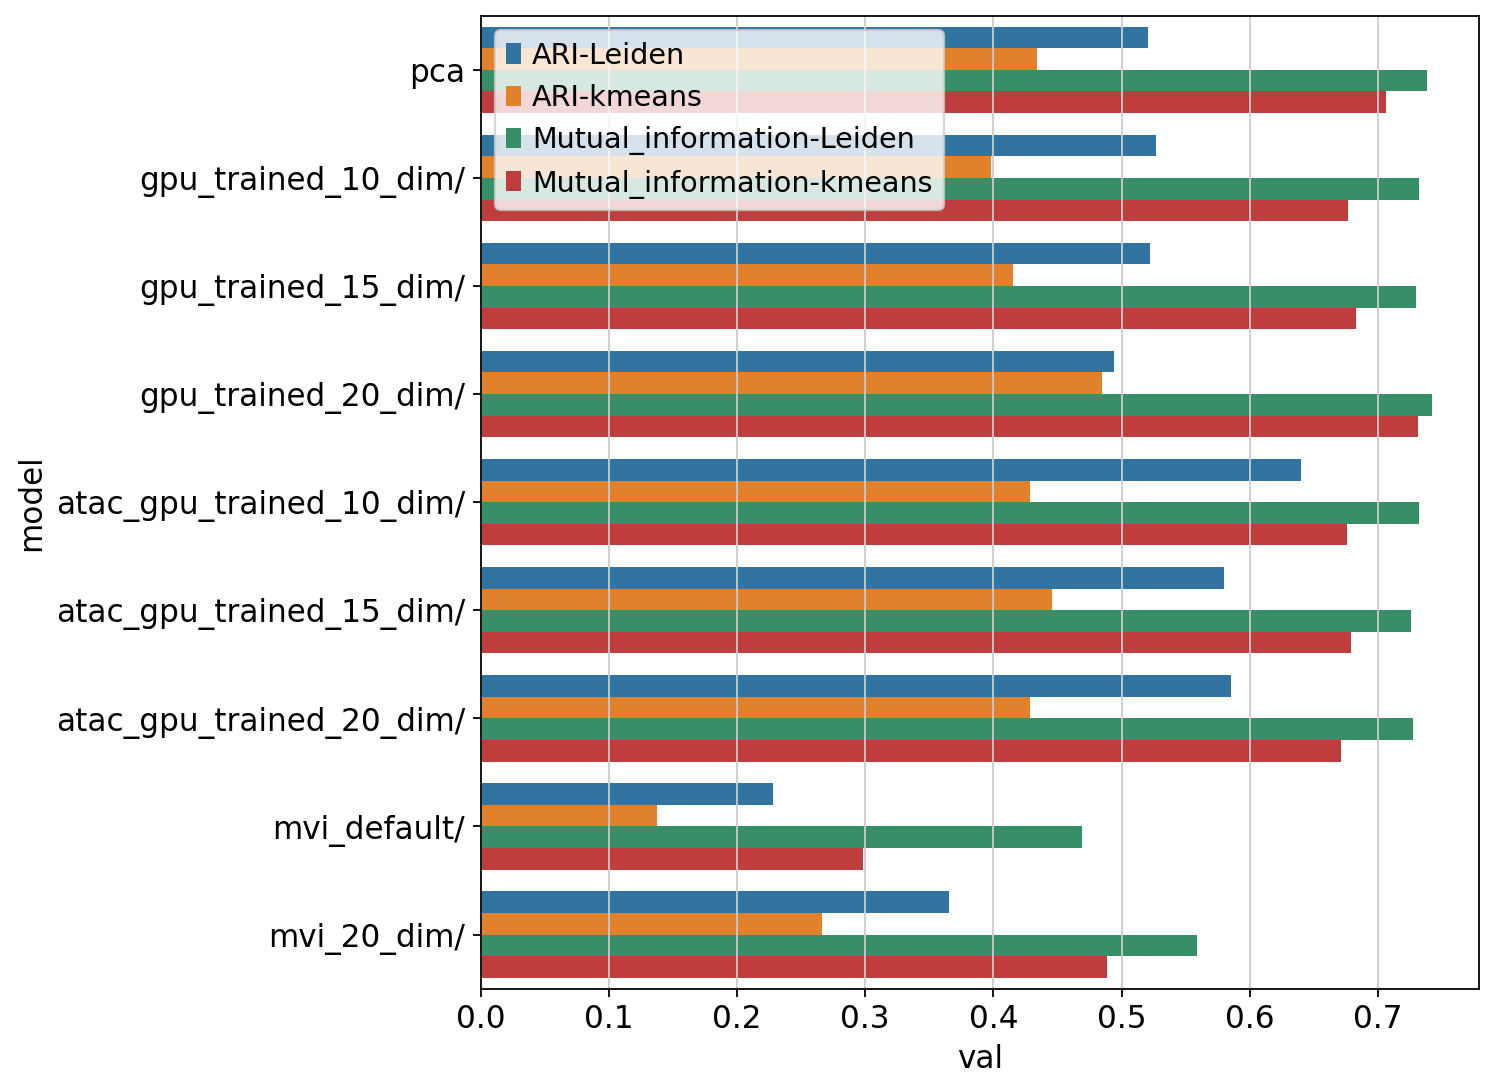

In [63]:
sns.barplot(y="model", x="val", hue="metric", data=df)
plt.legend(loc="upper left")

### 10 dimensional embedding

#### Leiden Clustering

In [42]:
# load anndata with latent space
adata = scvi.data.read_h5ad("gpu_trained_10_dim/anndata_object")

In [43]:
model = scvi.model.SCVI.load("gpu_trained_10_dim/", adata=adata, use_gpu=False)

/omics/groups/OE0533/internal/katharina/scvi2/lib/python3.7/site-packages/scvi/data/_utils.py:102: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  "Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization."


In [44]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.3)

In [45]:
sc.tl.leiden(adata, key_added="scVI_clusters", resolution=1.2)

In [46]:
print(f"Using Leiden clustering we obtain: {len(adata.obs.scVI_clusters.unique())} clusters")

Using Leiden clustering we obtain: 33 clusters


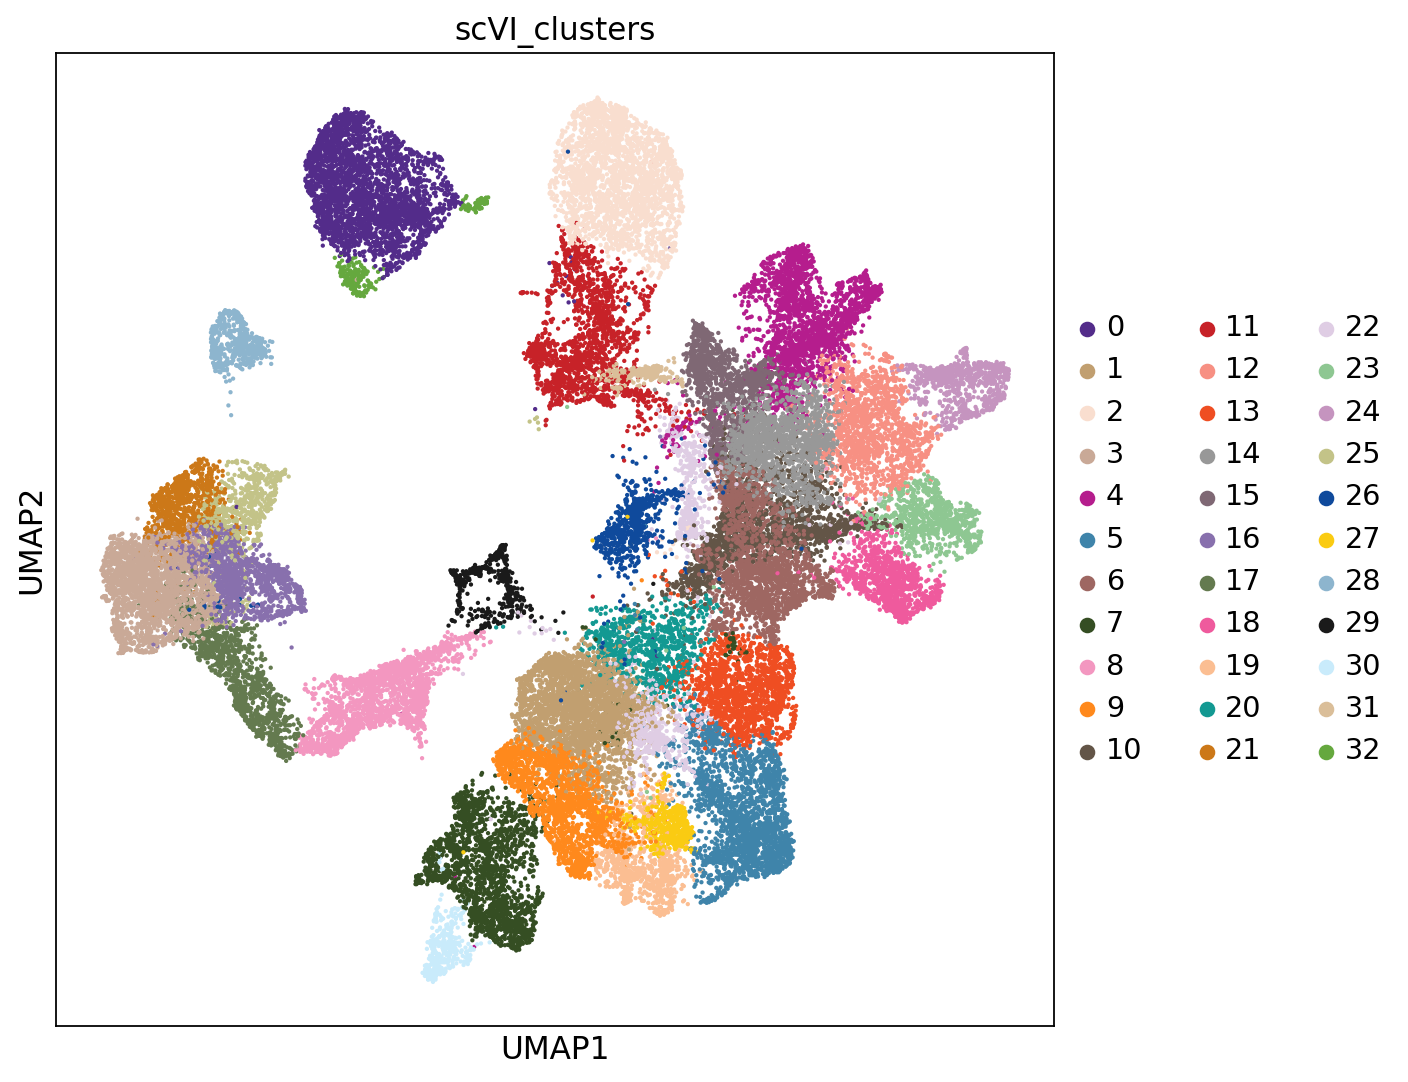

In [47]:
sc.set_figure_params(figsize=(8,8))
sc.pl.umap(adata, color="scVI_clusters", palette = colPalette_celltypes, size = 15)

In [48]:
print(f"The adjusted Rand index when using Leiden clustering is: {adjusted_rand_score(adata.obs.celltype, adata.obs.scVI_clusters)}")


The adjusted Rand index when using Leiden clustering is: 0.5271701664976636


In [49]:
metrics["rna_10_leiden"] =  adjusted_rand_score(adata.obs.celltype, adata.obs.scVI_clusters)

#### K-means clustering

In [50]:
emb = adata.obsm["X_scVI"]
kmeans = KMeans(n_clusters=37,
                init="random",
                n_init=200,
                random_state=0).fit(emb)


In [51]:
adata.obs["kmeans"] = kmeans.labels_.astype(str)

In [52]:
print(f"The adjusted Rand index when using k-means clustering is: {adjusted_rand_score(adata.obs.celltype, adata.obs.kmeans)}")

The adjusted Rand index when using k-means clustering is: 0.3978898887154553


In [53]:
metrics["rna_10_kmeans"] = adjusted_rand_score(adata.obs.celltype, adata.obs.kmeans)

### 15 dimensional embedding

#### Leiden Clustering

In [54]:
# load anndata with latent space
adata = scvi.data.read_h5ad("gpu_trained_15_dim/anndata_object")

In [55]:
model = scvi.model.SCVI.load("gpu_trained_15_dim/", adata=adata, use_gpu=False)

/omics/groups/OE0533/internal/katharina/scvi2/lib/python3.7/site-packages/scvi/data/_utils.py:102: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  "Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization."


In [56]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.3)

In [57]:
sc.tl.leiden(adata, key_added="scVI_clusters", resolution=1.2)

In [58]:
print(f"Using Leiden clustering we obtain: {len(adata.obs.scVI_clusters.unique())} clusters")

Using Leiden clustering we obtain: 32 clusters


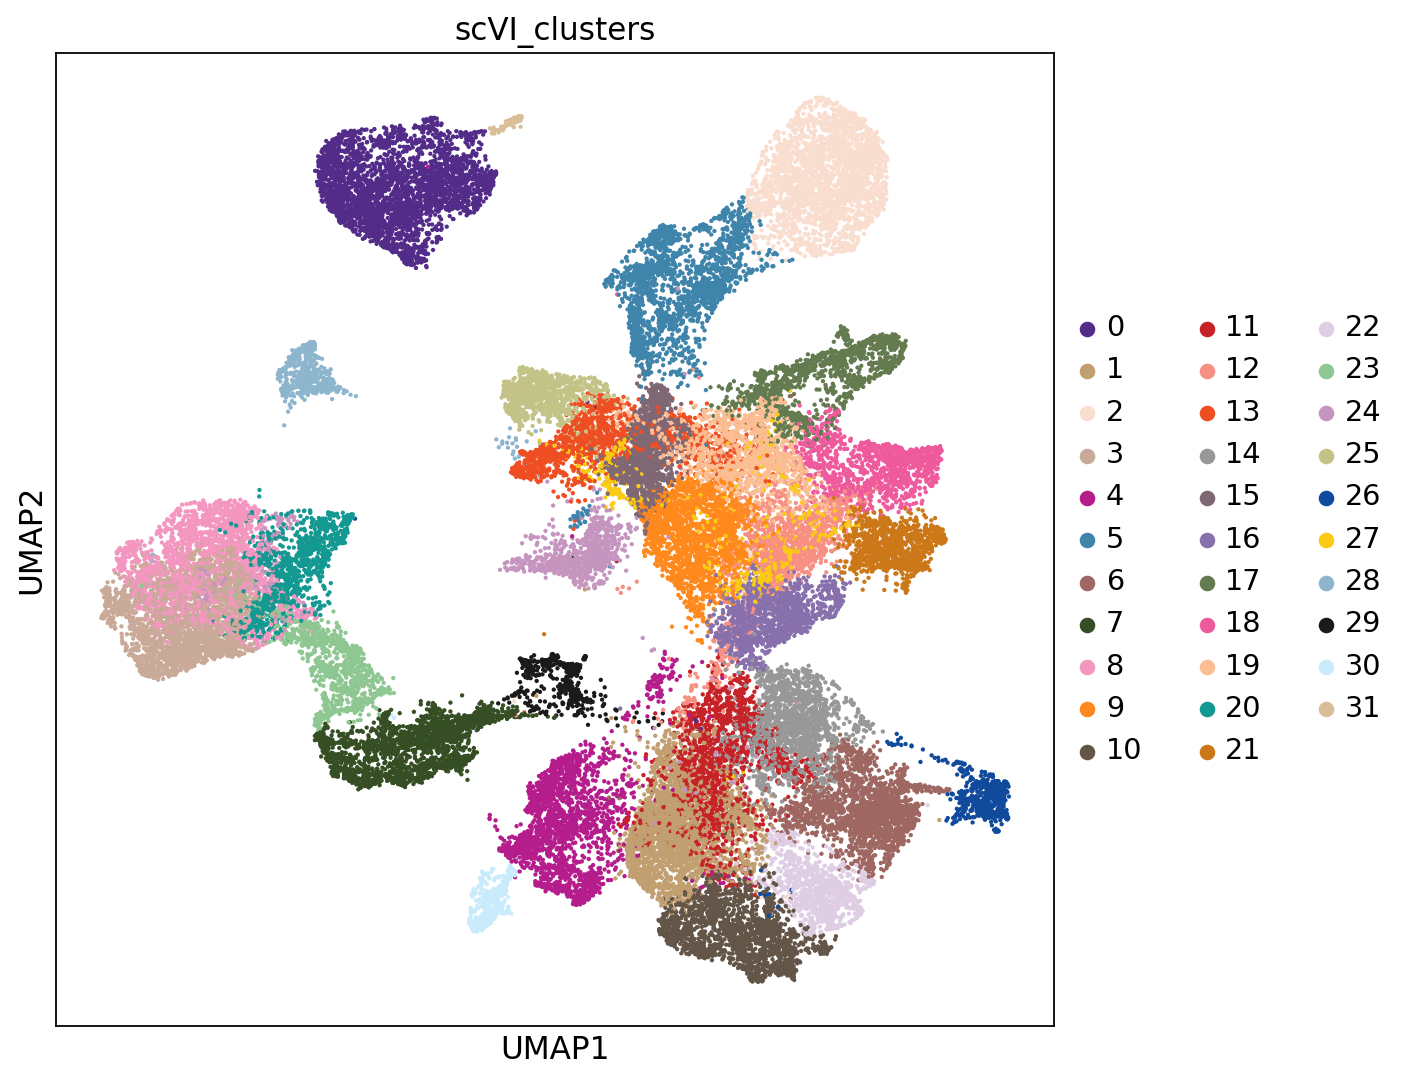

In [59]:
sc.set_figure_params(figsize=(8,8))
sc.pl.umap(adata, color="scVI_clusters", palette = colPalette_celltypes, size = 15)

In [60]:
print(f"The adjusted Rand index when using Leiden clustering is: {adjusted_rand_score(adata.obs.celltype, adata.obs.scVI_clusters)}")

The adjusted Rand index when using Leiden clustering is: 0.5219546301005924


In [61]:
metrics["rna_15_kmeans"] = adjusted_rand_score(adata.obs.celltype, adata.obs.kmeans)

AttributeError: 'DataFrame' object has no attribute 'kmeans'

#### K-means clustering

In [ ]:
emb = adata.obsm["X_scVI"]
kmeans = KMeans(n_clusters=37,
                init="random",
                n_init=200,
                random_state=0).fit(emb)


In [ ]:
adata.obs["kmeans"] = kmeans.labels_.astype(str)

In [ ]:
print(f"The adjusted Rand index when using k-means clustering is: {adjusted_rand_score(adata.obs.celltype, adata.obs.kmeans)}")

In [ ]:
metrics["rna_15_kmeans"] = adjusted_rand_score(adata.obs.celltype, adata.obs.kmeans)

### 20 dimensional embedding

#### Leiden Clustering

In [ ]:
# load anndata with latent space
adata = scvi.data.read_h5ad("gpu_trained_20_dim/anndata_object")

In [ ]:
model = scvi.model.SCVI.load("gpu_trained_20_dim/", adata=adata, use_gpu=False)

In [ ]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.3)

In [ ]:
sc.tl.leiden(adata, key_added="scVI_clusters", resolution=1.2)

In [ ]:
print(f"Using Leiden clustering we obtain: {len(adata.obs.scVI_clusters.unique())} clusters")

In [ ]:
sc.set_figure_params(figsize=(8,8))
sc.pl.umap(adata, color="scVI_clusters", palette = colPalette_celltypes, size = 15)

In [ ]:
print(f"The adjusted Rand index when using Leiden clustering is: {adjusted_rand_score(adata.obs.celltype, adata.obs.scVI_clusters)}")

In [ ]:
metrics["rna_20_kmeans"] = adjusted_rand_score(adata.obs.celltype, adata.obs.kmeans)

#### K-means clustering

In [ ]:
emb = adata.obsm["X_scVI"]
kmeans = KMeans(n_clusters=37,
                init="random",
                n_init=200,
                random_state=0).fit(emb)


In [ ]:
adata.obs["kmeans"] = kmeans.labels_.astype(str)

In [ ]:
print(f"The adjusted Rand index when using k-means clustering is: {adjusted_rand_score(adata.obs.celltype, adata.obs.kmeans)}")

In [ ]:
metrics["rna_20_kmeans"] = adjusted_rand_score(adata.obs.celltype, adata.obs.kmeans)

## scATAC-seq

### 10 dimensional embedding

#### Leiden Clustering

In [ ]:
# load anndata with latent space
adata = scvi.data.read_h5ad("atac_gpu_trained_10_dim/anndata_object_peakvi")

In [ ]:
pvi = scvi.model.PEAKVI.load("atac_gpu_trained_10_dim/", adata=adata, use_gpu=False)

In [ ]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="X_PeakVI")
sc.tl.umap(adata, min_dist=0.3)

In [ ]:
sc.tl.leiden(adata, key_added="PeakVI_clusters", resolution=1.2)

In [ ]:
print(f"Using Leiden clustering we obtain: {len(adata.obs.PeakVI_clusters.unique())} clusters")

In [ ]:
sc.set_figure_params(figsize=(8,8))
sc.pl.umap(adata, color="PeakVI_clusters", palette = colPalette_celltypes, size = 15)

In [ ]:
print(f"The adjusted Rand index when using Leiden clustering is: {adjusted_rand_score(adata.obs["celltype.mapped_mnn"], adata.obs.PeakVI_clusters)}")

In [ ]:
metrics["atac_10_leiden"] = adjusted_rand_score(adata.obs["celltype.mapped_mnn"], adata.obs.PeakVI_clusters)

#### K-means clustering

In [ ]:
emb = adata.obsm["X_PeakVI"]
kmeans = KMeans(n_clusters=37,
                init="random",
                n_init=200,
                random_state=0).fit(emb)


In [ ]:
adata.obs["kmeans"] = kmeans.labels_.astype(str)

In [ ]:
print(f"The adjusted Rand index when using k-means clustering is: {adjusted_rand_score(adata.obs.celltype, adata.obs.kmeans)}")

In [ ]:
metrics["atac_10_kmeans"] = adjusted_rand_score(adata.obs.celltype, adata.obs.kmeans)

### 15 dimensional embedding

#### Leiden Clustering

In [ ]:
# load anndata with latent space
adata = scvi.data.read_h5ad("atac_gpu_trained_15_dim/anndata_object_peakvi")

In [ ]:
pvi = scvi.model.PEAKVI.load("atac_gpu_trained_15_dim/", adata=adata, use_gpu=False)

In [ ]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="X_PeakVI")
sc.tl.umap(adata, min_dist=0.3)

In [ ]:
sc.tl.leiden(adata, key_added="PeakVI_clusters", resolution=1.2)

In [ ]:
print(f"Using Leiden clustering we obtain: {len(adata.obs.PeakVI_clusters.unique())} clusters")

In [ ]:
sc.set_figure_params(figsize=(8,8))
sc.pl.umap(adata, color="PeakVI_clusters", palette = colPalette_celltypes, size = 15)

In [ ]:
print(f"The adjusted Rand index when using Leiden clustering is: {adjusted_rand_score(adata.obs["celltype.mapped_mnn"], adata.obs.PeakVI_clusters)}")

In [ ]:
metrics["atac_15_leiden"] = adjusted_rand_score(adata.obs["celltype.mapped_mnn"], adata.obs.PeakVI_clusters)

#### K-means clustering

In [ ]:
emb = adata.obsm["X_PeakVI"]
kmeans = KMeans(n_clusters=37,
                init="random",
                n_init=200,
                random_state=0).fit(emb)


In [ ]:
adata.obs["kmeans"] = kmeans.labels_.astype(str)

In [ ]:
print(f"The adjusted Rand index when using k-means clustering is: {adjusted_rand_score(adata.obs.celltype, adata.obs.kmeans)}")

In [ ]:
metrics["atac_15_kmeans"] = adjusted_rand_score(adata.obs.celltype, adata.obs.kmeans)

### 20 dimensional embedding

#### Leiden Clustering

In [ ]:
# load anndata with latent space
adata = scvi.data.read_h5ad("atac_gpu_trained_20_dim/anndata_object_peakvi")

In [ ]:
pvi = scvi.model.PEAKVI.load("atac_gpu_trained_20_dim/", adata=adata, use_gpu=False)

In [ ]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="X_PeakVI")
sc.tl.umap(adata, min_dist=0.3)

In [ ]:
sc.tl.leiden(adata, key_added="PeakVI_clusters", resolution=1.2)

In [ ]:
print(f"Using Leiden clustering we obtain: {len(adata.obs.PeakVI_clusters.unique())} clusters")

In [ ]:
sc.set_figure_params(figsize=(8,8))
sc.pl.umap(adata, color="PeakVI_clusters", palette = colPalette_celltypes, size = 15)

In [ ]:
print(f"The adjusted Rand index when using Leiden clustering is: {adjusted_rand_score(adata.obs["celltype.mapped_mnn"], adata.obs.PeakVI_clusters)}")

In [ ]:
metrics["atac_20_leiden"] = adjusted_rand_score(adata.obs["celltype.mapped_mnn"], adata.obs.PeakVI_clusters)

#### K-means clustering

In [ ]:
emb = adata.obsm["X_PeakVI"]
kmeans = KMeans(n_clusters=37,
                init="random",
                n_init=200,
                random_state=0).fit(emb)


In [ ]:
adata.obs["kmeans"] = kmeans.labels_.astype(str)

In [ ]:
print(f"The adjusted Rand index when using k-means clustering is: {adjusted_rand_score(adata.obs.celltype, adata.obs.kmeans)}")

In [ ]:
metrics["atac_20_kmeans"] = adjusted_rand_score(adata.obs.celltype, adata.obs.kmeans)